We now incorporate oversampling and undersampling strategies into our supervised ML implementation. We will use `SMOTE` for oversampling and `RandomUnderSampler` for undersampling. These will be incorporated per CV split, post `StandardScaler`, but before `PCA`. In addition, we also include various methods for hyperparameter tuning, implemented per fold: `GridSearchCV`, `RandomisedSearchCV`, `BayesSearchCV`, and `HalvingSearchCV` (this last one is experimental). We introduce the usage of `SelectKBest` to feature selection to a specified number of features. We have also refactored the code so that a separate function handles the pre-processing.

# Initial imports

In [1]:
# Ignoring warnings here
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Data loading
import os
from glob import glob
from pathlib import Path
import joblib

# Key imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.stats import uniform, randint

# Preprocessing
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.base import clone

# ML implementation
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# Hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from skopt import BayesSearchCV

# Model evaluation
import sklearn.metrics as skmetrics
import imblearn.metrics as imbmetrics

# Using all labels

In [3]:
cwd = Path.cwd()
print(cwd)
prepped_data_dir = cwd / "PreppedData"

# If current path does not end in "PreppedData", move into it
if cwd.name != "PreppedData":
    if prepped_data_dir.exists():
        os.chdir(prepped_data_dir)
        print(f"Changed working directory to: {prepped_data_dir}")
    else:
        raise FileNotFoundError(f"'Annotations' directory not found at: {prepped_data_dir}")
else:
    print(f"Already in {cwd.name} directory.")

/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SupervisedML_v4
Changed working directory to: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SupervisedML_v4/PreppedData


In [4]:
# Load data, display relevant summary stats
n_split = 5
shuffle = True
random_state = 42

data = np.load('combined_logmed_transformed.npz')
X = data['X']
y = data['y']

print('X:')
display(X)
print('\nClass counts:', Counter(y))
print('\nX shape:', X.shape, 'y shape:', y.shape)
print('\nUnique class labels:', np.unique(y))

X:


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.47222030e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.29809237e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])


Class counts: Counter({np.int64(0): 1637, np.int64(1): 895, np.int64(2): 363, np.int64(4): 97, np.int64(3): 73})

X shape: (3065, 2947) y shape: (3065,)

Unique class labels: [0 1 2 3 4]


In [5]:
def stratcv(X, y, splits=5, shuffle=True, random_state=42, verbose=True):
    """
    Stratified K-Folds cross-validation splitter returning list of folds with train/val indices.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
    y : array-like, shape (n_samples,)
    splits : int
        Number of folds.
    shuffle : bool
        Whether to shuffle data before splitting.
    random_state : int
        Random seed for reproducibility.
    verbose : bool
        Whether to print label distribution info per fold.

    Returns
    -------
    folds : list of dict
        Each dict contains:
        - 'fold': fold number
        - 'train_idx': indices for training samples
        - 'val_idx': indices for validation samples
    """
    assert len(X) == len(y), "X and y must be the same length"

    folds = []
    cv = StratifiedKFold(n_splits=splits, shuffle=shuffle, random_state=random_state)

    # Using StratifiedKFold guarantees no overlap between the training and testing folds per split
    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        y_train, y_val = y[train_idx], y[val_idx]

        if verbose:
            print(f"\n=== Fold {i+1} ===")
            print("Train label distribution:", dict(Counter(y_train)))
            print("Validation label distribution:", dict(Counter(y_val)))

        folds.append({
            'fold': i+1,
            'train_idx': train_idx,
            'val_idx': val_idx,
        })

    return folds
    
folds = stratcv(X, y)


=== Fold 1 ===
Train label distribution: {np.int64(1): 716, np.int64(0): 1309, np.int64(3): 59, np.int64(2): 290, np.int64(4): 78}
Validation label distribution: {np.int64(1): 179, np.int64(0): 328, np.int64(3): 14, np.int64(2): 73, np.int64(4): 19}

=== Fold 2 ===
Train label distribution: {np.int64(1): 716, np.int64(0): 1309, np.int64(3): 59, np.int64(2): 290, np.int64(4): 78}
Validation label distribution: {np.int64(1): 179, np.int64(0): 328, np.int64(3): 14, np.int64(2): 73, np.int64(4): 19}

=== Fold 3 ===
Train label distribution: {np.int64(1): 716, np.int64(0): 1310, np.int64(3): 58, np.int64(2): 290, np.int64(4): 78}
Validation label distribution: {np.int64(1): 179, np.int64(0): 327, np.int64(3): 15, np.int64(2): 73, np.int64(4): 19}

=== Fold 4 ===
Train label distribution: {np.int64(1): 716, np.int64(0): 1310, np.int64(3): 58, np.int64(2): 291, np.int64(4): 77}
Validation label distribution: {np.int64(1): 179, np.int64(0): 327, np.int64(3): 15, np.int64(2): 72, np.int64(4): 

In [6]:
def normalised_cm(avg_cm, labels, normalise=['row', 'column'], save_path=None):
    """
    Plot confusion matrix heatmaps with specified normalisation(s) for multiclass classification.

    Accepted normalisation modes:
        - 'row': Normalise rows (per-class recall/sensitivity).
        - 'column': Normalise columns (per-class precision).
        - 'total': Normalise entire matrix by total (relative frequency).
        - 'raw': No normalisation (raw counts).

    Parameters:
        avg_cm (np.ndarray): Confusion matrix (e.g., averaged across CV folds), shape (n_classes, n_classes).
        labels (list of str): Class label names for tick marks.
        normalise (list of str): One or more of ['row', 'column', 'total', 'raw'].
        save_path (str or None): If provided, saves the figure to this path; otherwise, displays it.

    Returns:
        None
    """
    valid_opts = {'row', 'column', 'total', 'raw'}
    assert isinstance(normalise, list), "`normalise` must be a list of strings."
    assert all(n in valid_opts for n in normalise), f"Each entry in `normalise` must be one of: {valid_opts}"

    plots = []
    if 'row' in normalise:
        row_norm_cm = avg_cm / avg_cm.sum(axis=1, keepdims=True)
        plots.append(('Row-wise Normalised\n(Recall per true class)', row_norm_cm))

    if 'column' in normalise:
        col_norm_cm = avg_cm / avg_cm.sum(axis=0, keepdims=True)
        plots.append(('Column-wise Normalised\n(Precision per predicted class)', col_norm_cm))

    if 'total' in normalise:
        total_norm_cm = avg_cm / avg_cm.sum()
        plots.append(('Total Normalised\n(Relative frequencies)', total_norm_cm))

    if 'raw' in normalise:
        plots.append(('Raw Confusion Matrix\n(Counts)', avg_cm))

    n_plots = len(plots)
    plt.figure(figsize=(6 * n_plots, 5))

    for i, (title, cm) in enumerate(plots, 1):
        plt.subplot(1, n_plots, i)
        fmt = ".2f" if cm.dtype.kind == 'f' or not np.all(cm == cm.astype(int)) else "d"
        sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(title)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [7]:
def preprocess_pipeline(resampling='skip', use_varthreshold=True, 
                        use_stdscale=True,
                        use_pca=True, pca_variance=0.95, 
                        use_selectkbest=True, k_features=200, 
                        sampling_strategy='auto', random_state=42,
                        clf_params=None,
                        pca_params=None, skb_params=None,
                        verbose=0):
    """
    Constructs a pipeline for preprocessing MSI data and classification
    using an XGB classifier with optional variance thresholding, scaling, resampling, feature 
    selection, and PCA.

    Parameters:
    - resampling (str): Resampling strategy; one of 'skip', 'under', 'over', or 'combined'.
    - use_varthreshold (bool): Whether to apply VarianceThreshold to remove low-variance features.
    - use_stdscale (bool): Whether to apply StandardScaler for feature scaling.
    - use_pca (bool): Whether to apply PCA for dimensionality reduction.
    - pca_variance (float): Explained variance ratio for PCA n_components if pca_params not given.
    - use_selectkbest (bool): Whether to apply SelectKBest feature selection.
    - k_features (int): Number of top features to select with SelectKBest if skb_params not given.
    - sampling_strategy (str or dict): Sampling strategy for SMOTE-based resampling methods.
    - random_state (int): Random seed for reproducibility.
    - clf_params (dict or None): Parameters to override default SVC classifier settings.
    - pca_params (dict or None): Parameters to override default PCA settings.
    - skb_params (dict or None): Parameters to override default SelectKBest settings.
    - verbose (int): Verbosity level; if 2, prints pipeline steps.

    Returns:
    - pipeline (imblearn.pipeline.Pipeline): An imblearn Pipeline with all specified steps.
    """

    assert resampling in ['under', 'over', 'combined', 'skip'], "Parameter: resampling must be one of 'under', 'over', 'combined', 'skip'"
    
    steps = []

    if use_varthreshold:
        # Remove low-variance features before scaling/selection
        steps.append(('var_thresh', VarianceThreshold(threshold=1e-9)))
    
    if use_stdscale:
        steps.append(('scaler', StandardScaler()))

    if resampling == 'under':
        steps.append(('undersampler', RandomUnderSampler(random_state=random_state)))
    elif resampling == 'over':
        steps.append(('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)))
    elif resampling == 'combined':
        steps.append(('smoteenn', SMOTEENN(random_state=random_state)))

    base_estimator = XGBClassifier(eval_metric = 'mlogloss', random_state = random_state, n_jobs = -1)

    if clf_params is not None:
        base_estimator.set_params(**clf_params)
        
    if use_selectkbest:
        if skb_params is not None:
            if 'k' in skb_params:
                skb_params['k'] = int(skb_params['k'])
            steps.append(('skb', SelectKBest(score_func=f_classif, **skb_params)))
        else:
            steps.append(('skb', SelectKBest(score_func=f_classif, k=k_features)))

    if use_pca:
        if pca_params is not None:
            steps.append(('pca', PCA(**pca_params)))
        else:
            steps.append(('pca', PCA(n_components=pca_variance)))

    steps.append(('clf', base_estimator))

    pipeline = ImbPipeline(steps)

    if verbose == 2:
        print("Pipeline steps:")
        for name, step in pipeline.steps:
            print(f" - {name}: {step}")

    return pipeline

In [8]:
def xgb_v4(folds, X, y, verbose=0,
           scoring_fns=None, use_shuffled_labels=False, use_stdscale=True,
           use_pca=True, pca_variance=0.95, plot_cm_final=True, save_cm_final = False, save_final_results = False,
           dummy=False,
           resampling = 'skip', use_selectkbest=True,
           inner_splits = 3, tune_method=None, param_grid=None, 
           n_iter=10, tuning_metric='accuracy'):
    """
    Evaluate XGB (and optionally a Dummy Classifier) on cross-validation folds, 
    with optional standardisation, PCA, over/undersampling, and per-fold hyperparameter tuning.
    This finds the best params across folds.
    A preprocessing pipeline is automatically created based on the input parameter specs.

    Parameters
    ----------
    folds : list of dict
        List of CV splits. Each dict should contain:
        - 'fold': int (used for seeding randomness)
        - 'train_idx': indices for the training set
        - 'val_idx': indices for the validation set

    X : np.ndarray
        Feature matrix of shape (n_samples, n_features).

    y : np.ndarray
        Label vector of shape (n_samples,).

    verbose : int, default=0
        Verbosity level:
        - 0: Only final summary metrics
        - 1: Per-fold metrics
        - 2: Additional PCA info (e.g., number of components, explained variance)

    scoring_fns : dict of str -> callable, optional
        Custom scoring functions. Each function should take (y_true, y_pred) and return a score.
        Example: {"f1": f1_score, "roc": roc_auc_score}

    use_shuffled_labels : bool, default=False
        If True, shuffle labels in the training data (for diagnostic/random baseline testing).

    use_stdscale : bool, default=True
        If True, standardise features using StandardScaler.

    use_pca : bool, default=True
        If True, apply PCA to reduce dimensionality before classification.

    pca_variance : float or int, default=0.95
        - If float in (0, 1], retain enough components to preserve this proportion of variance.
        - If int ≥ 1, retain exactly this many components.

    use_selectkbest : bool, default=True
        If True, includes a SelectKBest feature selection step before classification.

    plot_cm_final : bool, default=True
        If True, plot the averaged confusion matrix over all CV folds.

    dummy : bool, default=False
        If True, fit and evaluate a DummyClassifier as a baseline.

    resampling : str, default='skip'
        Sampling strategy to be used in the preprocessing pipeline. Choose from:
        - 'skip': No data resampling
        - 'over': Oversampling on minority class(es) using SMOTE
        - 'under': Undersampling on majority class using RandomUnderSampler
        - 'combined': Combination of over- and under-sampling using SMOTEENN

    tune_method : str or None, default=None
        If provided, enables hyperparameter tuning using one of:
        - 'grid': GridSearchCV
        - 'random': RandomizedSearchCV
        - 'halving_grid': HalvingGridSearchCV
        - 'halving_random': HalvingRandomSearchCV
        - 'bayes': BayesSearchCV

    param_grid : dict, optional
        Parameter search space for the tuning method.
        Format:
        - For 'grid' or 'halving': each value should be a list of discrete options.
        - For 'random': values can be distributions or lists.
        - For 'bayes': values should follow skopt's format, e.g., (1e-3, 1e3, 'log-uniform').

    n_iter : int, default=10
        Number of parameter settings sampled in 'random' or 'bayes' search.
        Ignored if `tune_method` is 'grid' or 'halving'.
    
    tuning_metric : str, default='accuracy'
        Scoring metric to optimise during hyperparameter tuning. Must be a valid string accepted by 
        scikit-learn's `GridSearchCV`, `RandomizedSearchCV`, `HalvingGridSearchCV`, or `BayesSearchCV`.
        Examples include:
        - 'accuracy'
        - 'balanced_accuracy'
        - 'f1_macro'
        - 'roc_auc_ovr' (for multi-class ROC AUC)
        - 'neg_log_loss', etc.
    
        Ignored if `tune_method` is None.

    Returns
    -------
    dict
        Dictionary containing:
        - "xgb_scores": dict of list of scores for each scoring metric
        - "dummy_scores": dict of list of scores (if dummy=True), else None
        - "all_y_true": concatenated true labels across all folds (numpy array)
        - "all_y_pred": predicted labels across all folds (numpy array)
        - "cms": list of confusion matrices (one per fold)
        - "best_params": list of best params across CV folds
        - "cv_scores": list of tuning metric scores across CV folds
     """
    
    if not isinstance(verbose, int):
        raise TypeError("The 'verbose' parameter must be an integer: 0, 1, or 2.")
    
    valid_tuning = {'grid', 'random', 'halving_grid', 'halving_random', 'bayes', None}
    if tune_method not in valid_tuning:
        raise ValueError(f"Invalid resampling option '{tune_method}'. Must be one of {valid_tuning}.")

    unique_labels = np.unique(y)
    
    if scoring_fns is None:
        scoring_fns = make_scoring_fns(unique_labels)

    xgb_scores = {name: [] for name in scoring_fns}
    dummy_scores = {name: [] for name in scoring_fns} if dummy else None
    cms = []

    all_y_true = []
    all_y_pred = []
    best_params_list = []
    cv_scores_list = []

    print('Algorithm initialising...\n')

    if not use_stdscale and not use_pca:
        print("⚠️ Warning: Neither scaling nor PCA is applied — may affect model performance.")

    for fold in folds:
        train_idx = fold['train_idx']
        val_idx = fold['val_idx']

        X_train = X[train_idx]
        X_val = X[val_idx]
        y_train = y[train_idx]
        y_val = y[val_idx]

        if use_shuffled_labels:
            if verbose >= 1:
                print('Shuffling labels...\nNote that this is only a diagnostic tool.')
            rng = np.random.default_rng(seed=fold['fold'])
            y_train = rng.permutation(y_train)

        if verbose >= 2:
            print(f"\nOuter Fold {fold['fold']}")
            print(" Train label distribution:", Counter(y_train))
            print(" Val label distribution:  ", Counter(y_val))

        # Build pipeline with model_params=None; tuning will update these params in search
        if verbose >= 1:
            print('Building the specified pipeline...')
            
        pipeline = preprocess_pipeline(
            resampling=resampling,
            use_stdscale=use_stdscale,
            use_pca=use_pca,
            pca_variance = pca_variance,
            random_state=fold['fold'],
            verbose=verbose,
            clf_params=None,
            use_selectkbest = use_selectkbest,
        )
        
        if verbose == 2:
            for name, step in pipeline.steps:
                print(f" - {name}: {step}")
        
        # Dummy Classifier baseline
        if dummy:
            if verbose == 2:
                print('Prepping and fitting dummy classifier...')
            dummy_model = DummyClassifier(strategy='stratified')
            dummy_model.fit(X_train, y_train)
            y_dummy = dummy_model.predict(X_val)
            for name, fn in scoring_fns.items():
                try:
                    score = fn(y_val, y_dummy)
                    dummy_scores[name].append(score)
                except Exception as e:
                    print(f"[Dummy] {name} failed: {e}")

        # Hyperparameter tuning on pipeline
        if tune_method is not None:
            if param_grid is None:
                raise ValueError("Must provide a parameter grid, or the like, for hyperparameter tuning!")
            
            inner_cv = StratifiedKFold(n_splits = inner_splits, shuffle=True, random_state=fold['fold'])
            method = tune_method.lower()
            
            if method == 'grid':
                searcher = GridSearchCV(
                        pipeline, param_grid, scoring=tuning_metric, 
                        cv=inner_cv, n_jobs=-1, verbose=verbose, error_score='raise'
                        )
            elif method == 'random':
                searcher = RandomizedSearchCV(
                    pipeline, param_distributions=param_grid, n_iter=n_iter, scoring=tuning_metric,
                    cv=inner_cv, n_jobs=-1, verbose=verbose, random_state=fold['fold']
                )
            elif method == 'halving_grid':
                searcher = HalvingGridSearchCV(
                    pipeline, param_grid, scoring=tuning_metric, cv=inner_cv, factor=2,
                    verbose=verbose, n_jobs=-1
                )
            elif method == 'halving_random':
                searcher = HalvingRandomSearchCV(
                    pipeline, param_distributions=param_grid, n_candidates=n_iter, scoring=tuning_metric,
                    cv=inner_cv, n_jobs=-1, verbose=verbose, random_state=fold['fold']
                )
            elif method == 'bayes':
                searcher = BayesSearchCV(
                    pipeline, search_spaces=param_grid, n_iter=n_iter, scoring=tuning_metric,
                    cv=inner_cv, n_jobs=-1, verbose=verbose, random_state=fold['fold']
                )
            else:
                raise ValueError(f"Unknown tuning method: {tune_method}")

            if verbose >= 1:
                print(f'Tuning hyperparameters using method: {tune_method}...')
            searcher.fit(X_train, y_train)
            best_estimator = searcher.best_estimator_

            if verbose >= 1:
                print(f"Best hyperparameters (fold {fold['fold']}): {searcher.best_params_}")

            best_params_list.append(searcher.best_params_)
            cv_scores_list.append(searcher.best_score_)
            y_pred = best_estimator.predict(X_val)

        else:
            # No tuning — just fit the pipeline with default params
            pipeline.fit(X_train, y_train)
            best_estimator = pipeline
        
            best_params_list.append("default")
            cv_scores_list.append(None)
        
            y_pred = best_estimator.predict(X_val)

        if verbose == 2 and use_pca:
            pca_step = None
            if tune_method is not None:
                pca_step = next((step for name, step in best_estimator.named_steps.items() if name == 'pca'), None)
            else:
                pca_step = next((step for name, step in pipeline.steps if name == 'pca'), None)
                
            if pca_step is not None:
                print(f"PCA components retained: {pca_step.n_components_}")
                print(f"Explained variance ratio sum: {pca_step.explained_variance_ratio_.sum():.4f}")
                
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        if verbose >= 1:
            print("\nClassification Report:")
            print(skmetrics.classification_report(y_val, y_pred, labels=unique_labels, zero_division=0))

        for name, fn in scoring_fns.items():
            try:
                score = fn(y_val, y_pred)
                xgb_scores[name].append(score)
                if verbose >= 1:
                    print(f"{name}: {score:.4f}")
            except Exception as e:
                print(f"[XGB] {name} failed: {e}")

        cm = skmetrics.confusion_matrix(y_val, y_pred, labels=unique_labels)
        cms.append(cm)
        if verbose == 2:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
            fig, ax = plt.subplots(figsize=(6, 5))
            disp.plot(ax=ax, cmap='Blues', colorbar=False)
            ax.set_title(f'Confusion Matrix (Fold {fold["fold"]})')
            plt.tight_layout()
            plt.show()
            plt.close()

    if plot_cm_final and cms:
        avg_cm = np.mean(cms, axis=0)
        normalised_cm(avg_cm, unique_labels)
    if save_cm_final and cms:
        cwd = Path.cwd()
        output_dir = cwd / "ResultsCV"
        output_dir.mkdir(exist_ok=True)
        avg_cm = np.mean(cms, axis=0)
        save_path = output_dir / "final_normalised_confusion_matrix_xgb.png"
        normalised_cm(avg_cm, unique_labels, save_path=save_path)
        if verbose == 2:
            print(f"Saved final confusion matrix plot to {save_path}")

    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)

    print("\n=== Summary ===")
    if dummy:
        for name, scores in dummy_scores.items():
            scores = np.array(scores)
            print(f"Dummy — {name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            print('\n')
    for name, scores in xgb_scores.items():
        scores = np.array(scores)
        print(f"XGB — {name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    print("\n=== Final Averaged Classification Report Across All Folds ===")
    print(skmetrics.classification_report(all_y_true, all_y_pred, labels=unique_labels, zero_division=0))

    final_results = {
        "xgb_scores": xgb_scores,
        "dummy_scores": dummy_scores if dummy else None,
        "all_y_true": all_y_true,
        "all_y_pred": all_y_pred,
        "cms": cms,
        "best_params": best_params_list,
        "cv_scores": cv_scores_list
    }
    
    if save_final_results:
        cwd = Path.cwd()
        output_dir = cwd / "ResultsCV"
        output_dir.mkdir(exist_ok=True)
        with open(output_dir/"xgb_results.pkl", "wb") as f:
            joblib.dump(final_results, f)
    
    return final_results

In [9]:
def make_scoring_fns(unique_labels):
    """
    Create a dictionary of custom scoring functions for use in model evaluation or cross-validation.

    Each scoring function is configured to:
    - Handle class imbalance (via macro/weighted averaging and geometric mean).
    - Use consistent label handling across metrics.
    - Prevent division-by-zero warnings (e.g., for F1 with zero_division=0).

    Metrics included:
    - F1 Score (macro and weighted)
    - Geometric Mean Score (macro and weighted) from imbalanced-learn
    - Balanced Accuracy

    Parameters:
        unique_labels (list or array-like): List of all class labels expected in predictions.
                                            Used to ensure consistency in averaging.

    Returns:
        dict: A dictionary mapping human-readable metric names to scoring functions
              (callables accepting `y_true` and `y_pred`).
    """
    return {
        "F1 (macro)": lambda y_true, y_pred: skmetrics.f1_score(y_true, y_pred, average='macro', labels=unique_labels, zero_division=0),
        "F1 (weighted)": lambda y_true, y_pred: skmetrics.f1_score(y_true, y_pred, average='weighted', labels=unique_labels, zero_division=0),
        "G-Mean (macro)": lambda y_true, y_pred: imbmetrics.geometric_mean_score(y_true, y_pred, average='macro', labels=unique_labels),
        "G-Mean (weighted)": lambda y_true, y_pred: imbmetrics.geometric_mean_score(y_true, y_pred, average='weighted', labels=unique_labels),
        "Balanced Accuracy": lambda y_true, y_pred: skmetrics.balanced_accuracy_score(y_true, y_pred)
    }

In [10]:
gmean_macro = skmetrics.make_scorer(imbmetrics.geometric_mean_score, average='macro')
gmean_weighted = skmetrics.make_scorer(imbmetrics.geometric_mean_score, average='weighted')
balanced_accuracy = skmetrics.make_scorer(skmetrics.balanced_accuracy_score)
f1_macro = skmetrics.make_scorer(skmetrics.f1_score, average='macro')
f1_weighted = skmetrics.make_scorer(skmetrics.f1_score, average='weighted')

Algorithm initialising...

Building the specified pipeline...
Tuning hyperparameters using method: halving_grid...
n_iterations: 7
n_required_iterations: 11
n_possible_iterations: 7
min_resources_: 30
max_resources_: 2452
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1536
n_resources: 30
Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
----------
iter: 1
n_candidates: 768
n_resources: 60
Fitting 3 folds for each of 768 candidates, totalling 2304 fits


/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1536 fits failed out of a total of 2304.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1536 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", lin

----------
iter: 2
n_candidates: 384
n_resources: 120
Fitting 3 folds for each of 384 candidates, totalling 1152 fits
----------
iter: 3
n_candidates: 192
n_resources: 240
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 4
n_candidates: 96
n_resources: 480
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 5
n_candidates: 48
n_resources: 960
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 6
n_candidates: 24
n_resources: 1920
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters (fold 1): {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 10, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       328
           1       0.84  

/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1536 fits failed out of a total of 4608.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1536 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", lin

----------
iter: 1
n_candidates: 768
n_resources: 60
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
----------
iter: 2
n_candidates: 384
n_resources: 120
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
384 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
384 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", line 

----------
iter: 3
n_candidates: 192
n_resources: 240
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 4
n_candidates: 96
n_resources: 480
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 5
n_candidates: 48
n_resources: 960
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 6
n_candidates: 24
n_resources: 1920
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters (fold 2): {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 0.1, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       328
           1       0.80      0.82      0.81       179
           2       0.86      0.86      0.86        73
           3       0.67      0.43 

/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1536 fits failed out of a total of 4608.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1536 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", lin

----------
iter: 1
n_candidates: 768
n_resources: 60
Fitting 3 folds for each of 768 candidates, totalling 2304 fits


/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
768 fits failed out of a total of 2304.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
768 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", line 

----------
iter: 2
n_candidates: 384
n_resources: 120
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
384 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
384 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", line 

----------
iter: 3
n_candidates: 192
n_resources: 240
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 4
n_candidates: 96
n_resources: 480
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 5
n_candidates: 48
n_resources: 960
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 6
n_candidates: 24
n_resources: 1920
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters (fold 3): {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 6, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 0.1, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 150}

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       327
           1       0.83      0.77      0.80       179
           2       0.93      0.85      0.89        73
           3       1.00      0.47

/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1536 fits failed out of a total of 4608.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1536 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", lin

----------
iter: 1
n_candidates: 768
n_resources: 60
Fitting 3 folds for each of 768 candidates, totalling 2304 fits


/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
768 fits failed out of a total of 2304.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
768 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", line 

----------
iter: 2
n_candidates: 384
n_resources: 120
Fitting 3 folds for each of 384 candidates, totalling 1152 fits


/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
384 fits failed out of a total of 1152.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
384 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", line 

----------
iter: 3
n_candidates: 192
n_resources: 240
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 4
n_candidates: 96
n_resources: 480
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 5
n_candidates: 48
n_resources: 960
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 6
n_candidates: 24
n_resources: 1920
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters (fold 4): {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 6, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 0.1, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       327
           1       0.89      0.72      0.80       179
           2       0.89      0.88      0.88        72
           3       1.00      0.60

/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1536 fits failed out of a total of 4608.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1536 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fs1620/.local/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/fs1620/.conda/envs/ML_MSI/lib/python3.12/site-packages/imblearn/pipeline.py", lin

----------
iter: 1
n_candidates: 768
n_resources: 60
Fitting 3 folds for each of 768 candidates, totalling 2304 fits
----------
iter: 2
n_candidates: 384
n_resources: 120
Fitting 3 folds for each of 384 candidates, totalling 1152 fits
----------
iter: 3
n_candidates: 192
n_resources: 240
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 4
n_candidates: 96
n_resources: 480
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 5
n_candidates: 48
n_resources: 960
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 6
n_candidates: 24
n_resources: 1920
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters (fold 5): {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__reg_alpha': 1, 'clf__reg_lambda': 10, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 150}

Classification Report:
              pre

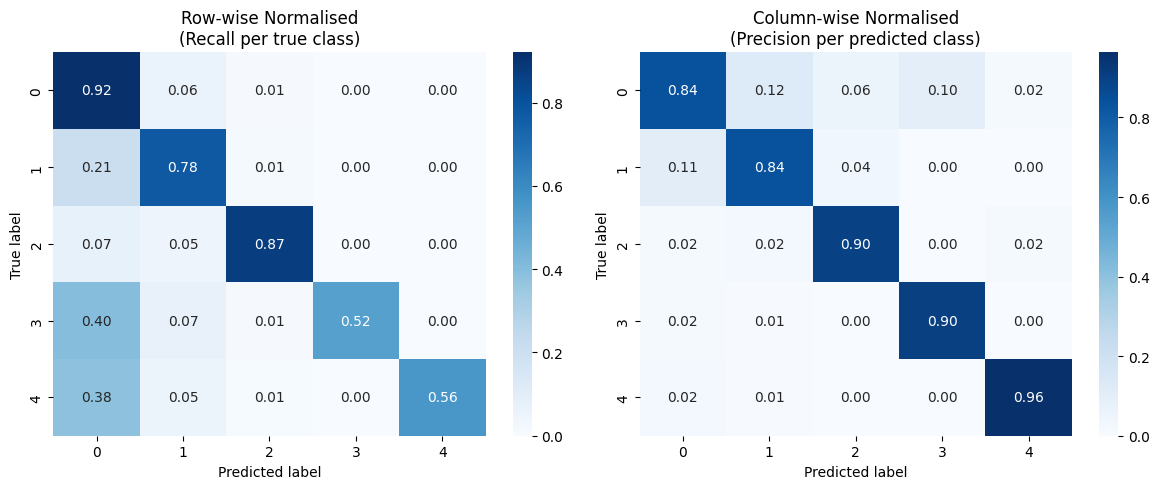


=== Summary ===
XGB — F1 (macro): 0.7838 ± 0.0362
XGB — F1 (weighted): 0.8482 ± 0.0099
XGB — G-Mean (macro): 0.8298 ± 0.0251
XGB — G-Mean (weighted): 0.8637 ± 0.0079
XGB — Balanced Accuracy: 0.7288 ± 0.0415

=== Final Averaged Classification Report Across All Folds ===
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1637
           1       0.84      0.78      0.81       895
           2       0.90      0.87      0.89       363
           3       0.90      0.52      0.66        73
           4       0.96      0.56      0.71        97

    accuracy                           0.85      3065
   macro avg       0.89      0.73      0.79      3065
weighted avg       0.85      0.85      0.85      3065



In [11]:
param_grid = [{
    'skb__k': [100, 150, 200, 250, 300, 350],         
    'pca__n_components': [0.85, 0.90, 0.95, 0.99],    
    'clf__n_estimators': [100, 300],                 
    'clf__max_depth': [3, 6],                        
    'clf__learning_rate': [0.01, 0.1],               
    'clf__subsample': [0.8],                         
    'clf__colsample_bytree': [0.8],                  
    'clf__gamma': [0, 1],                            
    'clf__reg_alpha': [0, 1],                        
    'clf__reg_lambda': [0.1, 10]                     
}]

fit_all_labels = xgb_v4(folds = folds, X = X, y = y, scoring_fns = None,
                           tune_method = 'halving_grid', param_grid = param_grid, n_iter = 10,
                           tuning_metric = gmean_macro, verbose = 1, resampling = 'skip',
                       save_cm_final = True, save_final_results = True)

In [12]:
def basic_aggregate(best_params_list):
    aggregated_params = {}
    keys = best_params_list[0].keys()
    for key in keys:
        values = [params[key] for params in best_params_list if key in params]
        
        if all(isinstance(v, bool) for v in values):
            aggregated_params[key] = Counter(values).most_common(1)[0][0]
        elif all(isinstance(v, (int, float, np.integer, np.floating)) for v in values):
            median_val = np.median(values)
            aggregated_params[key] = int(round(median_val)) if all(float(v).is_integer() for v in values) else float(median_val)
        else:
            aggregated_params[key] = Counter(values).most_common(1)[0][0]
    return aggregated_params
    
def aggregate_best_params(best_params_list, param_grid=None):
    """
    Aggregate a list of the best parameter dictionaries, ensuring consistency with the original parameter grid(s).

    Parameters:
        best_params_list (list of dict): Tuning results (e.g., from multiple CV folds).
        param_grid (list of dict): The original list of hyperparameter grids passed to a searcher 
                                   (e.g., GridSearchCV). Each defines a valid combination of parameters.

    Returns:
        dict or None: Aggregated representative parameter set or None if input is empty.
    """
    if not best_params_list or best_params_list[0] == "default":
        return None

    if param_grid is None:
        # fallback to simple mode
        return basic_aggregate(best_params_list)

    # Step 1: Flatten param_grid into sets of keys (parameter "schemas")
    grid_schemas = [set(d.keys()) for d in param_grid]

    # Step 2: Group best_params_list into those schemas
    grouped = defaultdict(list)
    for params in best_params_list:
        param_keys = set(params.keys())
        matched = False
        for schema in grid_schemas:
            if param_keys.issubset(schema):  # soft match
                grouped[frozenset(schema)].append(params)
                matched = True
                break
        if not matched:
            grouped["unknown"].append(params)  # fallback group

    # Step 3: Choose the group with most entries (most consistent config)
    best_group_key = max(grouped, key=lambda k: len(grouped[k]) if k != "unknown" else -1)
    selected_group = grouped[best_group_key]

    if not selected_group:
        return basic_aggregate(best_params_list)

    # Step 4: Aggregate selected group
    keys = best_group_key if isinstance(best_group_key, frozenset) else selected_group[0].keys()
    aggregated = {}
    for key in keys:
        values = [p[key] for p in selected_group if key in p]
        if not values:
            continue
        if all(isinstance(v, bool) for v in values):
            aggregated[key] = Counter(values).most_common(1)[0][0]
        elif all(isinstance(v, (int, float, np.integer, np.floating)) for v in values):
            median_val = np.median(values)
            aggregated[key] = int(round(median_val)) if all(float(v).is_integer() for v in values) else float(median_val)
        else:
            aggregated[key] = Counter(values).most_common(1)[0][0]

    return aggregated

In [13]:
best_params_list = fit_all_labels['best_params']
for i, params_list in enumerate(best_params_list):
    print(best_params_list[i])

{'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 10, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 100}
{'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 0.1, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 100}
{'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 6, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 0.1, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 150}
{'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.01, 'clf__max_depth': 6, 'clf__n_estimators': 300, 'clf__reg_alpha': 0, 'clf__reg_lambda': 0.1, 'clf__subsample': 0.8, 'pca__n_components': 0.99, 'skb__k': 100}
{'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0

In [14]:
consensus_set = aggregate_best_params(best_params_list, param_grid = param_grid)

clf_params = {k.replace('clf__', ''): v for k,v in consensus_set.items() if k.startswith('clf__')}
pca_params = {k.replace('pca__', ''): v for k,v in consensus_set.items() if k.startswith('pca__')}
skb_params = {k.replace('skb__', ''): v for k,v in consensus_set.items() if k.startswith('skb__')}

print('Final classifier hyperparameters:', clf_params)
print('Final PC fraction:', pca_params)
print('Final K-best features:', skb_params)

Final classifier hyperparameters: {'max_depth': 6, 'gamma': 0, 'reg_alpha': 0, 'n_estimators': 300, 'colsample_bytree': 0.8, 'reg_lambda': 0.1, 'subsample': 0.8, 'learning_rate': 0.1}
Final PC fraction: {'n_components': 0.99}
Final K-best features: {'k': 100}


In [15]:
final_pipeline = preprocess_pipeline(pca_params = pca_params, clf_params = clf_params, skb_params = skb_params)
print(final_pipeline)

Pipeline(steps=[('var_thresh', VarianceThreshold(threshold=1e-09)),
                ('scaler', StandardScaler()), ('skb', SelectKBest(k=100)),
                ('pca', PCA(n_components=0.99)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eva...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                      

In [16]:
final_pipeline.fit(X, y)

Pipeline(steps=[('var_thresh', VarianceThreshold(threshold=1e-09)),
                ('scaler', StandardScaler()), ('skb', SelectKBest(k=100)),
                ('pca', PCA(n_components=0.99)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eva...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [17]:
# Save model
# os.makedirs('TunedModels', exist_ok=True)
joblib.dump(final_pipeline, cwd/'TunedModels/xgb_v4_pipeline.pkl')

['/home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SupervisedML_v4/TunedModels/xgb_v4_pipeline.pkl']